In [1]:
from process import *
from visualize import *
from glycowork.motif.annotate import *
from glycowork.motif.graph import *
import os
import warnings
warnings.filterwarnings("ignore")


# Step 1 - Extracting PDB files from Glycoshape : https://glycoshape.io/

**data are saved in IUPAC folders when downloaded using dedicated functions**

In [132]:
### retrieve all available IUPAC sequences from glycoshape
iupac_list = get_glycoshape_IUPAC()

print(len(iupac_list))
print(iupac_list[0:3])

434
['Neu5Ac(a2-3)Gal(b1-4)GlcNAc(b1-2)[Neu5Ac(a2-3)Gal(b1-4)GlcNAc(b1-4)]Man(a1-3)[Neu5Ac(a2-3)Gal(b1-4)GlcNAc(b1-2)[Neu5Ac(a2-3)Gal(b1-4)GlcNAc(b1-6)]Man(a1-6)]Man(b1-4)GlcNAc(b1-4)GlcNAc', 'Fuc(a1-3)[Gal(b1-4)]GlcNAc(b1-3)Gal(b1-4)[Fuc(a1-3)]GlcNAc(b1-4)Glc', 'GlcNAc(b1-6)GalNAc']


In [133]:
download_from_glycoshape(iupac_list[0])

Error: Destination path 'Neu5Ac(a2-3)Gal(b1-4)GlcNAc(b1-2)[Neu5Ac(a2-3)Gal(b1-4)GlcNAc(b1-4)]Man(a1-3)[Neu5Ac(a2-3)Gal(b1-4)GlcNAc(b1-2)[Neu5Ac(a2-3)Gal(b1-4)GlcNAc(b1-6)]Man(a1-6)]Man(b1-4)GlcNAc(b1-4)GlcNAc/Neu5Ac(a2-3)Gal(b1-4)GlcNAc(b1-2)[Neu5Ac(a2-3)Gal(b1-4)GlcNAc(b1-4)]Man(a1-3)[Neu5Ac(a2-3)Gal(b1-4)GlcNAc(b1-2)[Neu5Ac(a2-3)Gal(b1-4)GlcNAc(b1-6)]Man(a1-6)]Man(b1-4)GlcNAc(b1-4)GlcNAc_alpha_0.pdb' already exists
Error: Destination path 'Neu5Ac(a2-3)Gal(b1-4)GlcNAc(b1-2)[Neu5Ac(a2-3)Gal(b1-4)GlcNAc(b1-4)]Man(a1-3)[Neu5Ac(a2-3)Gal(b1-4)GlcNAc(b1-2)[Neu5Ac(a2-3)Gal(b1-4)GlcNAc(b1-6)]Man(a1-6)]Man(b1-4)GlcNAc(b1-4)GlcNAc/Neu5Ac(a2-3)Gal(b1-4)GlcNAc(b1-2)[Neu5Ac(a2-3)Gal(b1-4)GlcNAc(b1-4)]Man(a1-3)[Neu5Ac(a2-3)Gal(b1-4)GlcNAc(b1-2)[Neu5Ac(a2-3)Gal(b1-4)GlcNAc(b1-6)]Man(a1-6)]Man(b1-4)GlcNAc(b1-4)GlcNAc_alpha_1.pdb' already exists
Error: Destination path 'Neu5Ac(a2-3)Gal(b1-4)GlcNAc(b1-2)[Neu5Ac(a2-3)Gal(b1-4)GlcNAc(b1-4)]Man(a1-3)[Neu5Ac(a2-3)Gal(b1-4)GlcNAc(b1-2)[Neu5Ac(a2-3)Gal(b1-4)

In [131]:
### Download full glycoshape
for g in iupac_list:
    download_from_glycoshape(g)

Error: Destination path 'Fuc(a1-3)[Gal(b1-4)]GlcNAc(b1-3)Gal(b1-4)[Fuc(a1-3)]GlcNAc(b1-4)Glc/Fuc(a1-3)[Gal(b1-4)]GlcNAc(b1-3)Gal(b1-4)[Fuc(a1-3)]GlcNAc(b1-4)Glc_alpha_0.pdb' already exists
Error: Destination path 'Fuc(a1-3)[Gal(b1-4)]GlcNAc(b1-3)Gal(b1-4)[Fuc(a1-3)]GlcNAc(b1-4)Glc/Fuc(a1-3)[Gal(b1-4)]GlcNAc(b1-3)Gal(b1-4)[Fuc(a1-3)]GlcNAc(b1-4)Glc_alpha_1.pdb' already exists
Error: Destination path 'Fuc(a1-3)[Gal(b1-4)]GlcNAc(b1-3)Gal(b1-4)[Fuc(a1-3)]GlcNAc(b1-4)Glc/Fuc(a1-3)[Gal(b1-4)]GlcNAc(b1-3)Gal(b1-4)[Fuc(a1-3)]GlcNAc(b1-4)Glc_alpha_2.pdb' already exists
Error: Destination path 'Fuc(a1-3)[Gal(b1-4)]GlcNAc(b1-3)Gal(b1-4)[Fuc(a1-3)]GlcNAc(b1-4)Glc/Fuc(a1-3)[Gal(b1-4)]GlcNAc(b1-3)Gal(b1-4)[Fuc(a1-3)]GlcNAc(b1-4)Glc_alpha_3.pdb' already exists
Error: Destination path 'Fuc(a1-3)[Gal(b1-4)]GlcNAc(b1-3)Gal(b1-4)[Fuc(a1-3)]GlcNAc(b1-4)Glc/Fuc(a1-3)[Gal(b1-4)]GlcNAc(b1-3)Gal(b1-4)[Fuc(a1-3)]GlcNAc(b1-4)Glc_alpha_4.pdb' already exists
Error: Destination path 'Fuc(a1-3)[Gal(b1-4)]GlcNAc(b1-

In [172]:
### download PDB files from glycoshape
# files are saved in a folder named as the IUPAC sequence
#download_from_glycoshape(iupac_list[0])
iupac_list[0] = "Neu5Ac(a2-6)Gal(b1-4)GlcNAc(b1-2)Man(a1-3)[Neu5Ac(a2-6)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)]Man(b1-4)GlcNAc(b1-4)GlcNAc"
#iupac_list[0] = "Neu5Ac(a2-6)Gal(b1-4)GlcNAc(b1-2)Man(a1-3)[Neu5Ac(a2-3)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)]Man(b1-4)GlcNAc(b1-4)GlcNAc"
#g = "Fuc(a1-2)Gal(b1-3)GalNAc"
g = "Neu5Gc(a2-3)Gal(b1-3)GlcNAc"



In [173]:
### Check what are the different PDB files downloaded

pdbs = check_available_pdb(g)
pdbs

['Neu5Gc(a2-3)Gal(b1-3)GlcNAc_beta_8.pdb',
 'Neu5Gc(a2-3)Gal(b1-3)GlcNAc_alpha_8.pdb',
 'Neu5Gc(a2-3)Gal(b1-3)GlcNAc_alpha_5.pdb',
 'Neu5Gc(a2-3)Gal(b1-3)GlcNAc_beta_2.pdb',
 'Neu5Gc(a2-3)Gal(b1-3)GlcNAc_beta_3.pdb',
 'Neu5Gc(a2-3)Gal(b1-3)GlcNAc_alpha_4.pdb',
 'Neu5Gc(a2-3)Gal(b1-3)GlcNAc_alpha_6.pdb',
 'Neu5Gc(a2-3)Gal(b1-3)GlcNAc_beta_1.pdb',
 'Neu5Gc(a2-3)Gal(b1-3)GlcNAc_beta_0.pdb',
 'Neu5Gc(a2-3)Gal(b1-3)GlcNAc_alpha_7.pdb',
 'Neu5Gc(a2-3)Gal(b1-3)GlcNAc_alpha_3.pdb',
 'Neu5Gc(a2-3)Gal(b1-3)GlcNAc_beta_4.pdb',
 'Neu5Gc(a2-3)Gal(b1-3)GlcNAc_beta_5.pdb',
 'Neu5Gc(a2-3)Gal(b1-3)GlcNAc_alpha_2.pdb',
 'Neu5Gc(a2-3)Gal(b1-3)GlcNAc_alpha_0.pdb',
 'Neu5Gc(a2-3)Gal(b1-3)GlcNAc_beta_7.pdb',
 'Neu5Gc(a2-3)Gal(b1-3)GlcNAc_beta_6.pdb',
 'Neu5Gc(a2-3)Gal(b1-3)GlcNAc_alpha_1.pdb']

# Step 2 - Extracting 3D coordinates from PDB files and replacing PDB to IUPAC nomenclature

In [174]:
pdb_file = g + "/" + pdbs[0]
pdb_file

'Neu5Gc(a2-3)Gal(b1-3)GlcNAc/Neu5Gc(a2-3)Gal(b1-3)GlcNAc_beta_8.pdb'

In [175]:
get_glycan_sequence_from_path(pdb_file)

'Neu5Gc(a2-3)Gal(b1-3)GlcNAc'

In [176]:
### an annotation pipeline is applied on the file to replace PDB with IUPAC nomenclature (explanations in appendix 1)
df = explore_threshold(pdb_file, threshold_list=[2.4,2.5,2.6,2.7,2.8,2.9,2.45,2.55,2.65,2.75,2.85,2.95,3,2.2,2.25,2.3,2.35,3.5])
df

threshold:2.4
glycowork and glycontact agree on the list of covalent linkages
Building a network from glycontact interactions generate a single molecule, as expected


,record_name,atom_number,atom_name,monosaccharide,chain_id,residue_number,x,y,z,occupancy,temperature_factor,element,IUPAC
0,ATOM,1,HO1,ROH,X,1,15.550,19.179,27.120,1.0,0.0,H,-R
1,ATOM,2,O1,ROH,X,1,16.373,19.301,26.651,1.0,0.0,O,-R
2,ATOM,3,C1,NAG,X,2,16.423,19.429,25.228,1.0,0.0,C,GlcNAc(b1-1)
3,ATOM,4,H1,NAG,X,2,15.895,20.366,25.050,1.0,0.0,H,GlcNAc(b1-1)
4,ATOM,5,C2,NAG,X,2,17.868,19.399,24.645,1.0,0.0,C,GlcNAc(b1-1)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,ATOM,84,OHG,NGC,X,4,31.189,25.430,22.340,1.0,0.0,O,Neu5Gc(a2-3)
84,ATOM,85,HOG,NGC,X,4,31.000,25.869,23.170,1.0,0.0,H,Neu5Gc(a2-3)
85,ATOM,86,O5N,NGC,X,4,28.853,24.189,23.290,1.0,0.0,O,Neu5Gc(a2-3)
86,ATOM,87,O4,NGC,X,4,28.184,21.386,21.560,1.0,0.0,O,Neu5Gc(a2-3)


# Step 3 - Creating a distance table between monosaccharides

### Explanations
For each pair of monosaccharides i and j in the glycan structure, where i and j are integers ranging from 1 to the total number of monosaccharides in the structure (n), the distance (d) between every atom pair is computed as follows:<br><br>
d(i, j) = |xi - xj| + |yi - yj| + |zi - zj|<br><br>
Where:<br>
xi, yi, zi are the coordinates of an atom from the i-th monosaccharide,<br>
xj, yj, zj are the coordinates of an atom from the j-th monosaccharide,<br>
|xi - xj|, |yi - yj|, |zi - zj| are the absolute differences between atomic coordinates of an atom pair between the i-th and j-th monosaccharides. The distance between the closest pair of atoms from two monosaccharides is used as a proxy of the monosaccharide pair distance.<br><br>
This formula calculates the Manhattan distance (also known as L1 norm) between the i-th and j-th monosaccharides in the 3D space.


In [177]:
# table containing observed inter-monosaccharide distances
dist_table = make_monosaccharide_contact_table(df,mode='distance')

# table containing observed inter-monosaccharide distances only if closer to each other than 3A
dist_table_closer = make_monosaccharide_contact_table(df,mode='distance',threshold=3)

# table containing 0 or 1 if inter-monosaccharide distance is above or below the default threshold (10A)
binary_table = make_monosaccharide_contact_table(df,mode='binary')


In [19]:
dist_table

,1_-R,2_GlcNAc(b1-1),3_GlcNAc(b1-4),4_Man(b1-4),5_Man(a1-6),6_GlcNAc(b1-6),7_Gal(b1-4),8_Neu5Ac(a2-3),9_GlcNAc(b1-2),10_Gal(b1-4),11_Neu5Ac(a2-3),12_Man(a1-3),13_GlcNAc(b1-4),14_Gal(b1-4),15_Neu5Ac(a2-3),16_GlcNAc(b1-2),17_Gal(b1-4),18_Neu5Ac(a2-3)
0,0.000,2.295,9.473,11.000,11.000,11.000,11.000,9.600,11.000,11.000,4.031,11.000,11.000,11.000,7.805,11.000,11.000,11.000
1,2.295,0.000,2.140,11.000,11.000,9.448,11.000,3.406,7.643,7.409,2.039,11.000,6.818,5.845,2.624,11.000,11.000,11.000
2,9.473,2.140,0.000,2.357,4.362,3.570,7.148,4.285,3.405,5.344,3.799,4.423,4.353,7.056,7.804,11.000,11.000,11.000
3,11.000,11.000,2.357,0.000,2.454,6.739,11.000,11.000,4.506,8.504,9.828,1.784,4.456,7.347,11.000,3.729,11.000,11.000
4,11.000,11.000,4.362,2.454,0.000,1.951,9.745,11.000,2.109,8.929,11.000,8.341,9.870,11.000,11.000,4.275,11.000,11.000
5,11.000,9.448,3.570,6.739,1.951,0.000,2.004,5.026,2.939,2.525,7.407,11.000,11.000,11.000,11.000,11.000,11.000,11.000
6,11.000,11.000,7.148,11.000,9.745,2.004,0.000,2.264,5.515,2.737,4.464,11.000,11.000,11.000,11.000,11.000,11.000,11.000
7,9.600,3.406,4.285,11.000,11.000,5.026,2.264,0.000,7.201,3.307,2.923,11.000,11.000,11.000,11.000,11.000,11.000,11.000
8,11.000,7.643,3.405,4.506,2.109,2.939,5.515,7.201,0.000,2.051,6.283,8.613,7.581,6.805,9.215,7.672,11.000,11.000
9,11.000,7.409,5.344,8.504,8.929,2.525,2.737,3.307,2.051,0.000,2.124,11.000,11.000,8.985,7.822,11.000,11.000,11.000


# Step 4 - Visualizing inter-monosaccharide contact maps

Distance matrices are difficult to interpret and therefore, converted into contact maps

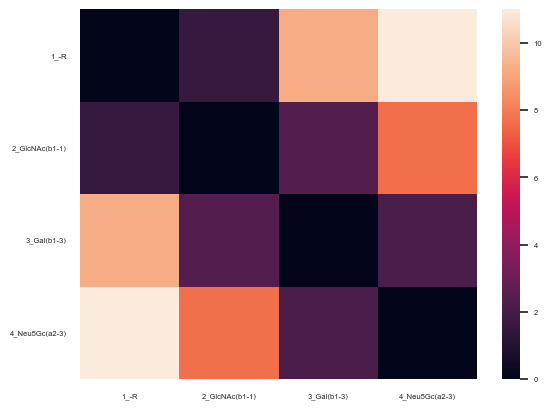

In [178]:
# On contact maps, smaller distances are darker. 

#Here we see two big squares, representing two parts of the glycan. 
# Each part is in tighter interaction with itself than with the other part.
# They correspond respectively to the "trunk" GlcNAc(b1-4)[Fuc(a1-6)]GlcNAc and the "branches" Man(a1-6)[Man(a1-3)]Man(b1-4) of the glycan respectively
monosaccharide_contact_map(dist_table)

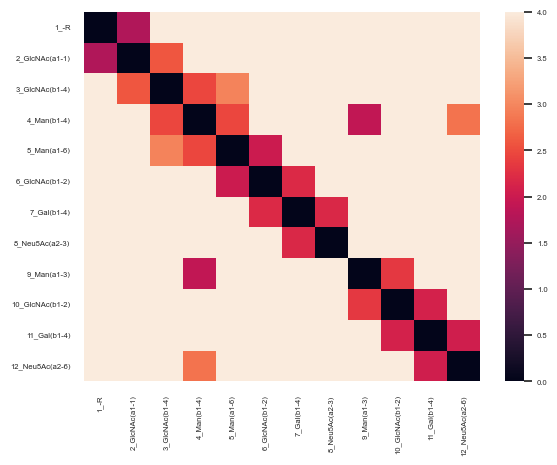

In [106]:
# With a map limited to very close interactions, we can only see binary covalent linkages
monosaccharide_contact_map(dist_table_closer)

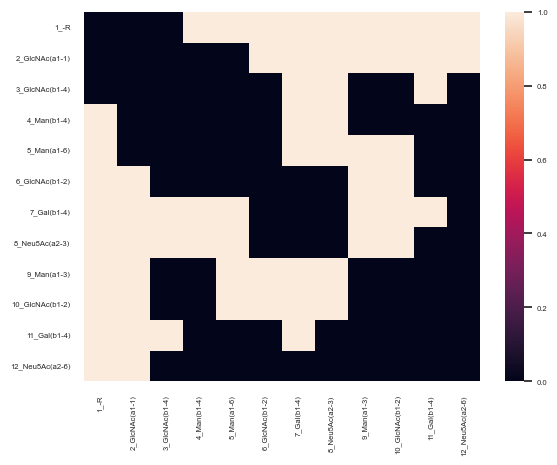

In [107]:
# The binary contact map is just a simplified fingerprint of the interactions, according to a given distance threshold
monosaccharide_contact_map(binary_table)

# Step 5 - Creating a distance table between atoms and visualizing intra- and inter-monosaccharide interactions at the atomic level

### Explanations
Same principle as for monosaccharides, but all distances of all atom pairs are kept.

Distance between atoms from the same monosaccharide can be included (inclusive mode) or ignored and set to 0 (exclusive mode)

In [179]:
# table containing observed inter-atomic distances excluding interactions between atoms from the same monosaccharide
dist_table = make_atom_contact_table(df,mode='exclusive')

# table containing observed inter-atomic distances including interactions between atoms from the same monosaccharide
inclusive_dist_table = make_atom_contact_table(df,mode='inclusive')

# setting a very high-threshold allows to visualize all interatomic relations
all_inclusive_dist_table = make_atom_contact_table(df,mode='inclusive', threshold = 200)

In [25]:
dist_table

,1_-R_HO1_1,1_-R_O1_2,2_GlcNAc(b1-1)_C1_3,2_GlcNAc(b1-1)_H1_4,2_GlcNAc(b1-1)_C2_5,2_GlcNAc(b1-1)_H2_6,2_GlcNAc(b1-1)_N2_7,2_GlcNAc(b1-1)_H2N_8,2_GlcNAc(b1-1)_C2N_9,2_GlcNAc(b1-1)_CME_10,...,18_Neu5Ac(a2-3)_N5_447,18_Neu5Ac(a2-3)_H5N_448,18_Neu5Ac(a2-3)_C5N_449,18_Neu5Ac(a2-3)_CME_450,18_Neu5Ac(a2-3)_H3M_451,18_Neu5Ac(a2-3)_H2M_452,18_Neu5Ac(a2-3)_H1M_453,18_Neu5Ac(a2-3)_O5N_454,18_Neu5Ac(a2-3)_O4_455,18_Neu5Ac(a2-3)_H4O_456
0,0.000,0.000,2.952,4.036,4.923,4.944,4.867,4.854,6.965,8.175,...,11.0,11.0,11.0,11.0,11.0,11,11.0,11.0,11.0,11.0
1,0.000,0.000,2.295,3.529,3.610,3.631,3.634,4.395,5.732,6.942,...,11.0,11.0,11.0,11.0,11.0,11,11.0,11.0,11.0,11.0
2,2.952,2.295,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,11.0,11.0,11.0,11.0,11.0,11,11.0,11.0,11.0,11.0
3,4.036,3.529,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,11.0,11.0,11.0,11.0,11.0,11,11.0,11.0,11.0,11.0
4,4.923,3.610,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,11.0,11.0,11.0,11.0,11.0,11,11.0,11.0,11.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,11.000,11.000,11.000,11.000,11.000,11.000,11.000,11.000,11.000,11.000,...,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
452,11.000,11.000,11.000,11.000,11.000,11.000,11.000,11.000,11.000,11.000,...,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
453,11.000,11.000,11.000,11.000,11.000,11.000,11.000,11.000,11.000,11.000,...,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
454,11.000,11.000,11.000,11.000,11.000,11.000,11.000,11.000,11.000,11.000,...,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0


In [18]:
all_inclusive_dist_table

,1_ROH_HO1_1,1_ROH_O1_2,2_NDG_C1_3,2_NDG_H1_4,2_NDG_O5_5,2_NDG_C5_6,2_NDG_H5_7,2_NDG_C6_8,2_NDG_H62_9,2_NDG_H61_10,...,7_MAN_H61_131,7_MAN_O6_132,7_MAN_H6O_133,7_MAN_O5_134,7_MAN_O4_135,7_MAN_H4O_136,7_MAN_O3_137,7_MAN_H3O_138,7_MAN_O2_139,7_MAN_H2O_140
0,0.000,1.636,2.786,2.955,2.867,4.365,3.474,6.509,7.549,6.305,...,22.067,22.109,20.788,19.854,24.400,25.783,25.970,26.036,23.864,25.011
1,1.636,0.000,2.226,3.129,3.471,5.133,4.242,7.277,8.317,7.073,...,21.507,21.549,20.228,19.294,23.840,25.223,25.410,25.476,23.304,24.451
2,2.786,2.226,0.000,1.817,2.279,3.941,3.984,6.085,7.125,5.881,...,19.281,19.323,18.002,17.068,21.614,22.997,23.184,23.250,21.078,22.225
3,2.955,3.129,1.817,0.000,3.280,4.942,5.801,7.086,8.126,6.882,...,19.112,19.154,17.833,16.899,21.445,22.828,23.015,23.081,20.909,22.056
4,2.867,3.471,2.279,3.280,0.000,2.360,3.533,3.806,4.846,3.602,...,19.200,19.242,17.921,16.987,21.533,22.916,23.103,23.169,20.997,22.144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,25.783,25.223,22.997,22.828,22.916,23.240,24.733,23.570,23.920,25.102,...,5.982,6.792,7.449,5.929,1.383,0.000,3.619,3.691,6.381,7.096
136,25.970,25.410,23.184,23.015,23.103,23.427,24.920,23.757,24.107,25.289,...,8.151,8.961,9.618,6.116,3.770,3.619,0.000,1.416,3.642,4.323
137,26.036,25.476,23.250,23.081,23.169,23.493,24.986,23.823,24.173,25.355,...,9.567,10.377,11.034,7.084,4.888,3.691,1.416,0.000,4.920,5.601
138,23.864,23.304,21.078,20.909,20.997,21.321,22.814,21.651,22.001,23.183,...,7.491,5.975,6.632,4.010,6.532,6.381,3.642,4.920,0.000,1.181


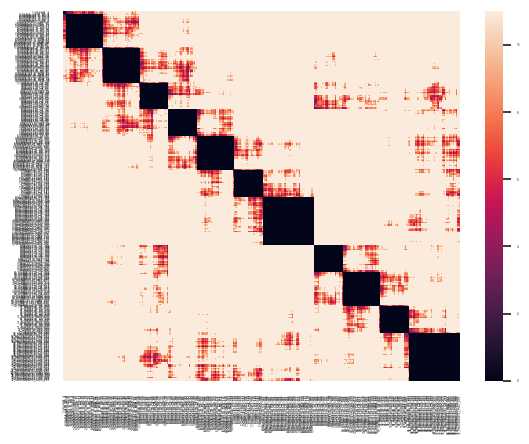

In [109]:
atom_contact_map(dist_table,size = 0.2)

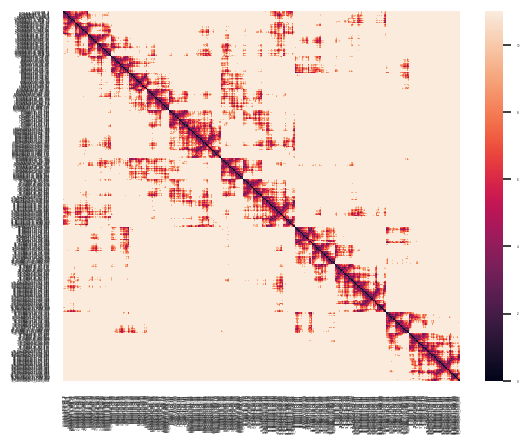

In [27]:
atom_contact_map(inclusive_dist_table,size = 0.2)

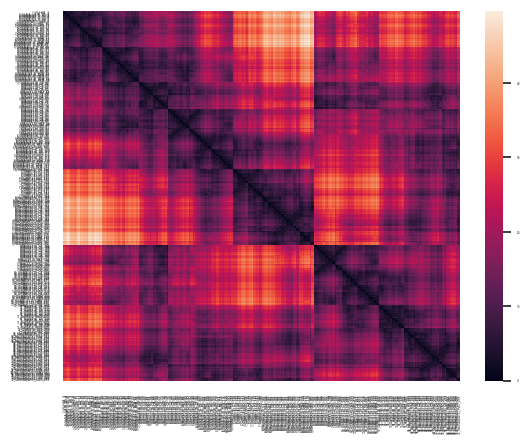

In [110]:
atom_contact_map(all_inclusive_dist_table,size = 0.2)

# Step 6 - Visualizing multiple structures of the same glycan

For a given glycan, multiple structures (or clusters) are determined.
It is therefore possible to generate multiple maps and create a gif to visualize them

threshold:2.4
glycowork and glycontact do not agree on the list of covalent linkages in this glycan. It is probable that glycontact encountered a problem with PDB monosaccharide conversion, or detecting linkages
threshold:2.5
glycowork and glycontact agree on the list of covalent linkages
Building a network from glycontact interactions generate a single molecule, as expected


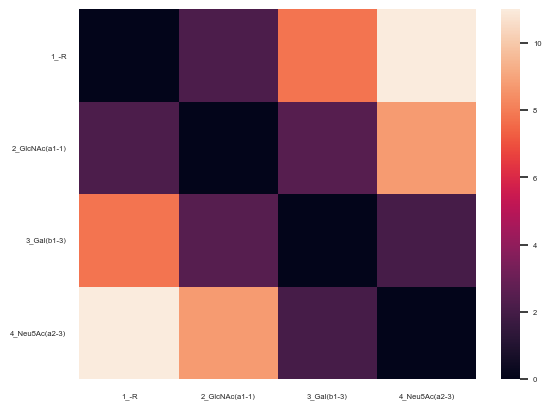

threshold:2.4
glycowork and glycontact agree on the list of covalent linkages
Building a network from glycontact interactions generate a single molecule, as expected


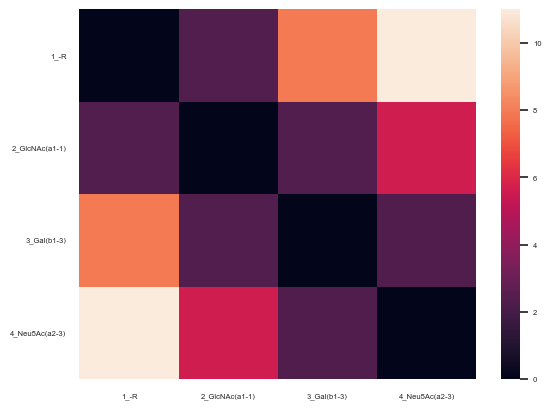

threshold:2.4
glycowork and glycontact do not agree on the list of covalent linkages in this glycan. It is probable that glycontact encountered a problem with PDB monosaccharide conversion, or detecting linkages
threshold:2.5
glycowork and glycontact do not agree on the list of covalent linkages in this glycan. It is probable that glycontact encountered a problem with PDB monosaccharide conversion, or detecting linkages
threshold:2.6
glycowork and glycontact agree on the list of covalent linkages
Building a network from glycontact interactions generate a single molecule, as expected


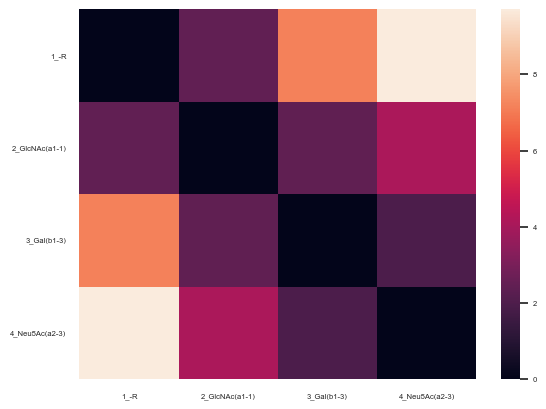

In [164]:
### Monosaccharide contact maps from alpha linked molecules
# Select alpha-linked glycan pdb files
alpha_pdbs = [pdb for pdb in pdbs if 'alpha' in pdb]
alpha_pdbs

x = 0
for f in alpha_pdbs :
    df = explore_threshold(f.split('_')[0]+'/'+ f, threshold_list=[2.4,2.5,2.6,2.7,2.8,2.9,2.45,2.55,2.65,2.75,2.85,2.95,3])
    dist_table = make_monosaccharide_contact_table(df,mode='distance')
    monosaccharide_contact_map(dist_table, export=str(x)+'_'+f.split('_')[0]+'_alpha.png')
    x+=1

#Create a gif
make_gif(prefix= 'monosaccharide_alpha',suffix= f.split('_')[0]+'_alpha')

In [ ]:
# Similarly, atomic maps are exported
x = 0
for f in alpha_pdbs :
    df = explore_threshold(f.split('_')[0]+'/'+ f, threshold_list=[2.4,2.5,2.6,2.7,2.8,2.9,2.45,2.55,2.65,2.75,2.85,2.95,3])
    dist_table = make_atom_contact_table(df,mode='exclusive')
    atom_contact_map(dist_table, export=str(x)+'_'+f.split('_')[0]+'_alpha_atomic.png')
    x+=1

#Create a gif
make_gif(prefix= 'monosaccharide_alpha_atomic',suffix= f.split('_')[0]+'_alpha_atomic')

# Atomic maps including all distances
x = 0
for f in alpha_pdbs :
    df = explore_threshold(f.split('_')[0]+'/'+ f, threshold_list=[2.4,2.5,2.6,2.7,2.8,2.9,2.45,2.55,2.65,2.75,2.85,2.95,3])
    dist_table = make_atom_contact_table(df,mode='inclusive',threshold=200)
    atom_contact_map(dist_table, export=str(x)+'_'+f.split('_')[0]+'_alpha_atomic_full.png')
    x+=1

#Create a gif
make_gif(prefix= 'monosaccharide_alpha_atomic_full',suffix= f.split('_')[0]+'_alpha_atomic_full')



# Step 7 - Determination of stable monosaccharide/atom pairs across structural clusters

### Explanations
Two methods can be specified to determine monosaccharide/atom stability across structural clusters.

Method 1:<br>
For each pair of entities pE (monosaccharide or atom) in each structure S, the average distance D is computed as follows:<br><br>
D(pE) = (D(pE_S1) + D(pE_S2) + ... + D(pE_Sn)) / n<br><br>
Where:<br>
pE is a pair of entities (monosaccharide or atom),<br>
D(pE_Si) is the distance between the pair of entities in the i-th structure, n is the total number of structures.<br><br>
Then, the instability score I for the pair of entities pE is computed as follows:<br><br>
I(pE) = SUM(|D(pE_S1) - D(pE)|, |D(pE_S2) - D(pE)|, ..., |D(pE_Sn) - D(pE)|)<br><br>
Where:<br>
I(pE) is the instability score for the pair of entities pE,<br>
SUM is the sum of all absolute differences between the distance of the pair of entities in each structure and the average distance.<br><br><br>
Method 2 (amplify):<br>
The second method is similar to the first one, but in the last step, the power of 2of the instability score is used instead.

In [180]:

### Monosaccharide contact maps from alpha linked molecules
# Select alpha-linked glycan pdb files
alpha_pdbs = [pdb for pdb in pdbs if 'alpha' in pdb]


# read all structures and get contact maps
dfs = []
atom_dfs = []
for f in alpha_pdbs :
    df = explore_threshold(f.split('_')[0]+'/'+ f, threshold_list=[2.4,2.5,2.6,2.7,2.8,2.9,2.45,2.55,2.65,2.75,2.85,2.95,3])
    dist_table = make_monosaccharide_contact_table(df,mode='distance', threshold = 200)
    atom_dist_table = make_atom_contact_table(df,mode='inclusive', threshold = 200)
    dfs.append(dist_table)
    atom_dfs.append(atom_dist_table)

# from the contact maps, compute standard and amplified inter-structure variability tables
isvt_amplified = inter_structure_variability_table(dfs, 'amplify')
isvt = inter_structure_variability_table(dfs)

atom_isvt_amplified = inter_structure_variability_table(atom_dfs, 'amplify')
atom_isvt = inter_structure_variability_table(atom_dfs)

threshold:2.4
glycowork and glycontact agree on the list of covalent linkages
Building a network from glycontact interactions generate a single molecule, as expected
threshold:2.4
glycowork and glycontact do not agree on the list of covalent linkages in this glycan. It is probable that glycontact encountered a problem with PDB monosaccharide conversion, or detecting linkages
threshold:2.5
glycowork and glycontact do not agree on the list of covalent linkages in this glycan. It is probable that glycontact encountered a problem with PDB monosaccharide conversion, or detecting linkages
threshold:2.6
glycowork and glycontact agree on the list of covalent linkages
Building a network from glycontact interactions generate a single molecule, as expected
threshold:2.4
glycowork and glycontact agree on the list of covalent linkages
Building a network from glycontact interactions generate a single molecule, as expected
threshold:2.4
glycowork and glycontact agree on the list of covalent linkages


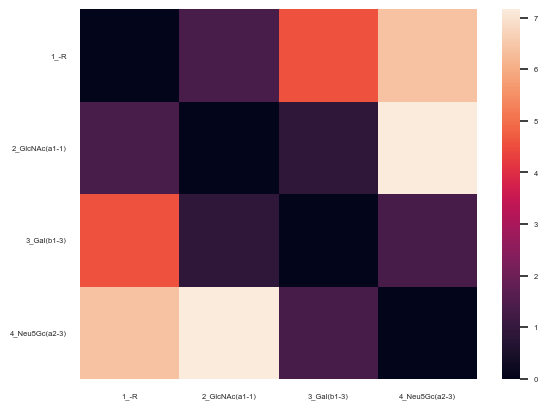

In [181]:
# Instability across structure is represented by bright colors. 
# The darker, the most stable monosaccharide pairs are across structures.
monosaccharide_contact_map(isvt)

<Axes: >

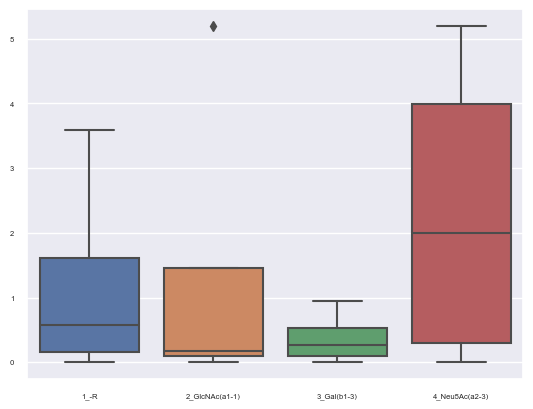

In [168]:
# monosaccharide instability can also be visualized through seaborn boxplots
sns.boxplot(isvt)

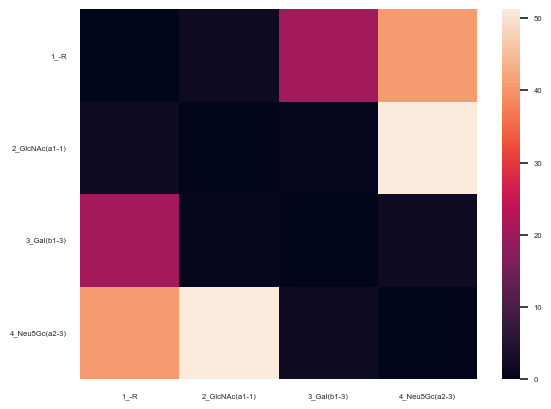

In [182]:
# Differences in terms of stability are exacerbated with the amplified mode
monosaccharide_contact_map(isvt_amplified)

<Axes: >

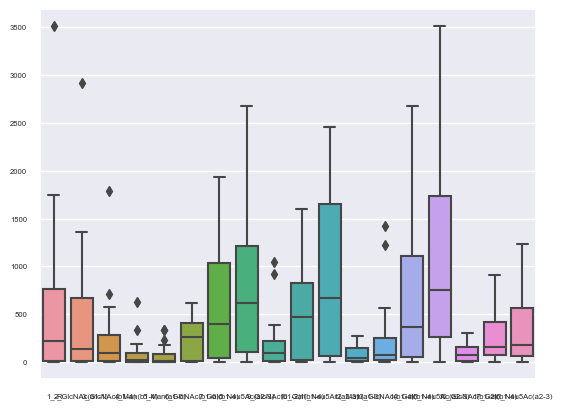

In [53]:
# Differences in terms of stability are exacerbated with the amplified mode also in the boxplots
sns.boxplot(isvt_amplified)

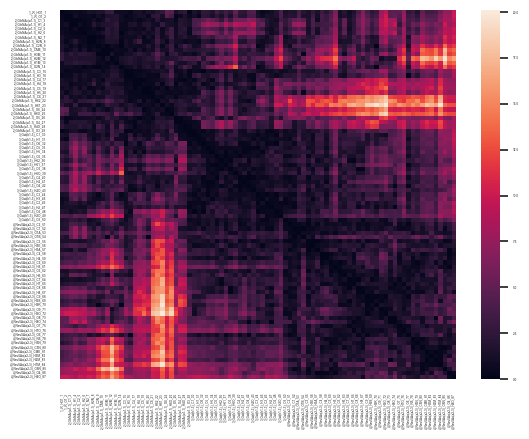

In [170]:
# Atom contact maps are higher-resolution versions of monosaccharide contact maps
atom_contact_map(atom_isvt,size =0.2)

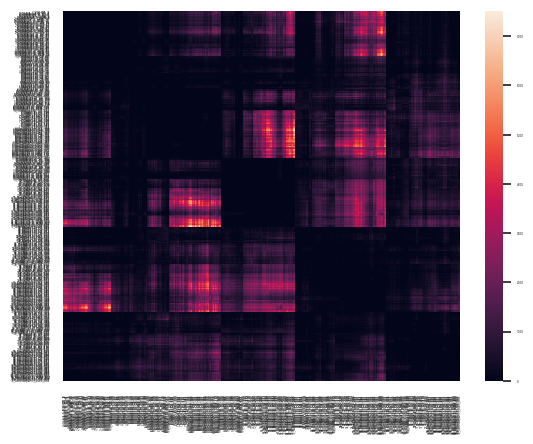

In [55]:
atom_contact_map(atom_isvt_amplified,size =0.2)

In [59]:
# We can search for the most stable and unstable monosaccharides, here 5_Man(a1-6) and 15_Neu5Ac(a2-3) respectively
# Interestingly, 18_Neu5Ac(a2-3) is much more stable (276.5) than the three others (430.2 to 512.7)

residue_overall_stability = {}
for c in isvt.columns.to_list():
    residue_overall_stability[c] = sum(isvt[c].to_list())

sorted_residue_overall_stability = sorted(residue_overall_stability.items(), key=lambda x:x[1])
print(sorted_residue_overall_stability)

[('5_Man(a1-6)', 107.48500000000001), ('4_Man(b1-4)', 123.12350000000005), ('12_Man(a1-3)', 125.76499999999994), ('16_GlcNAc(b1-2)', 151.63349999999997), ('9_GlcNAc(b1-2)', 205.99450000000002), ('13_GlcNAc(b1-4)', 218.37099999999998), ('3_GlcNAc(b1-4)', 222.245), ('6_GlcNAc(b1-6)', 241.55349999999999), ('17_Gal(b1-4)', 250.64950000000005), ('18_Neu5Ac(a2-3)', 276.49949999999995), ('2_GlcNAc(a1-1)', 298.86100000000005), ('1_-R', 325.15149999999994), ('10_Gal(b1-4)', 335.60599999999994), ('7_Gal(b1-4)', 342.76699999999994), ('14_Gal(b1-4)', 378.45500000000004), ('8_Neu5Ac(a2-3)', 430.249), ('11_Neu5Ac(a2-3)', 445.1625000000001), ('15_Neu5Ac(a2-3)', 512.6659999999999)]


In [58]:
# Similarly, we can search for the most stable and unstable atoms, here 15_Neu5Ac(a2-3)_H3M_366 is the most unstable

residue_overall_stability = {}
for c in atom_isvt.columns.to_list():
    residue_overall_stability[c] = sum(atom_isvt[c].to_list())

sorted_residue_overall_stability = sorted(residue_overall_stability.items(), key=lambda x:x[1])
print(sorted_residue_overall_stability)

[('4_Man(b1-4)_H4O_69', 3641.653999999998), ('4_Man(b1-4)_O4_68', 3729.0844999999977), ('12_Man(a1-3)_H1_268', 3750.042499999998), ('4_Man(b1-4)_H4_67', 3773.4120000000007), ('12_Man(a1-3)_C1_267', 3834.7504999999996), ('4_Man(b1-4)_C4_66', 3849.425999999999), ('12_Man(a1-3)_H2_270', 3867.8740000000016), ('12_Man(a1-3)_C2_269', 3918.3899999999985), ('4_Man(b1-4)_O3_76', 3958.3225000000007), ('16_GlcNAc(b1-2)_H1_373', 4011.6990000000033), ('12_Man(a1-3)_O2_286', 4019.278999999998), ('16_GlcNAc(b1-2)_C1_372', 4034.1174999999967), ('4_Man(b1-4)_O6_65', 4098.195499999999), ('12_Man(a1-3)_O5_282', 4151.161000000002), ('4_Man(b1-4)_C3_70', 4162.2975000000015), ('16_GlcNAc(b1-2)_O5_374', 4227.335999999997), ('5_Man(a1-6)_C1_77', 4245.407500000001), ('4_Man(b1-4)_C5_60', 4323.758999999999), ('4_Man(b1-4)_C6_62', 4334.150500000002), ('4_Man(b1-4)_H3_71', 4359.406500000003), ('5_Man(a1-6)_O5_91', 4369.384499999997), ('5_Man(a1-6)_C3_81', 4375.457999999999), ('12_Man(a1-3)_C3_271', 4387.440500000

# Step 8 - From PDB to Pearson correlations

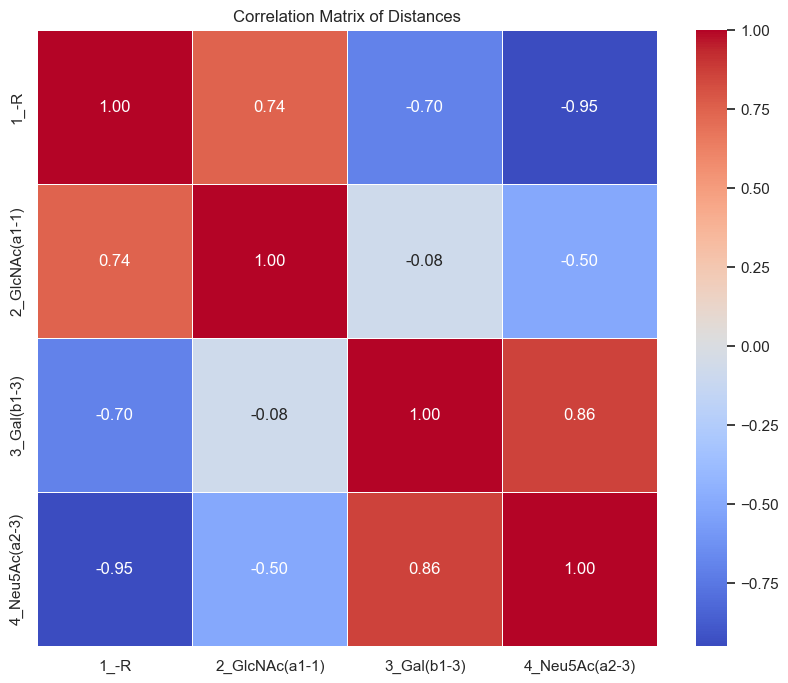

In [171]:
mx = make_correlation_matrix(dfs)
show_correlations(mx)

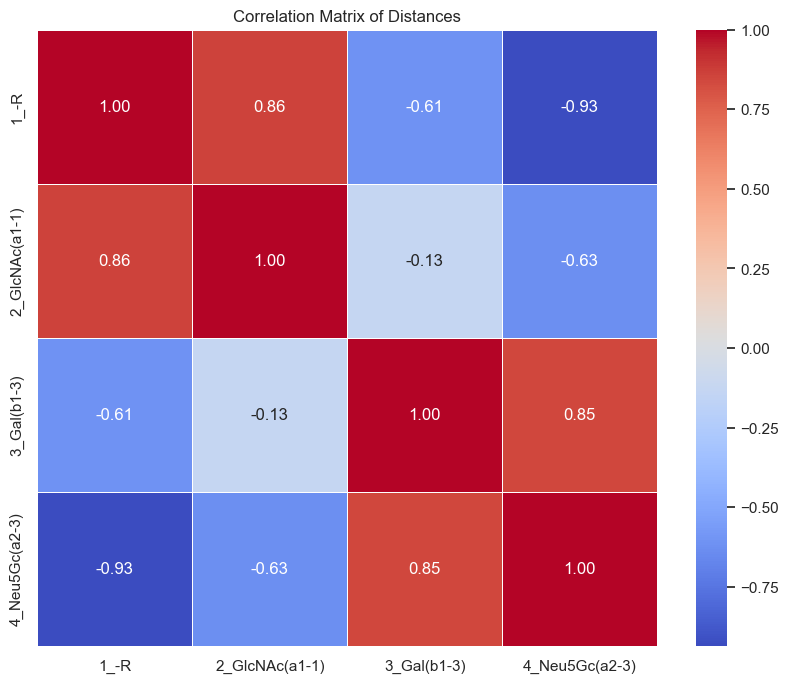

In [183]:
# Computing the correlation matrix and displaying it as a heatmap

mx = make_correlation_matrix(dfs)
show_correlations(mx)

# On the map, high values (red) between the relative distances of a pair of residues compared to all other residues. 
# 0 (white) means no correlation
# Low negative values (blue) mean anti-correlations
# Here, the terminal Glc(a1-2)Glc(a1-3)Glc(a1-3)Man(a1-2)Man(a1-2) part of the glycan shows a strong intra-correlation 
# but no positive correlation to the rest of the molecule, suggesting its structural independancy


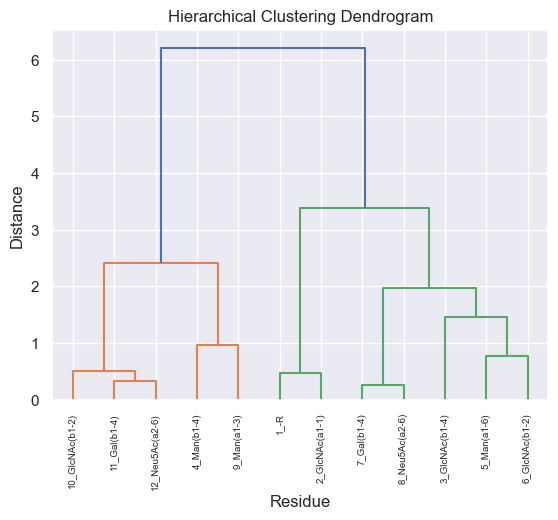

In [130]:
# clustering of correlated residues
show_correlation_dendrogram(mx, font_size = 7)

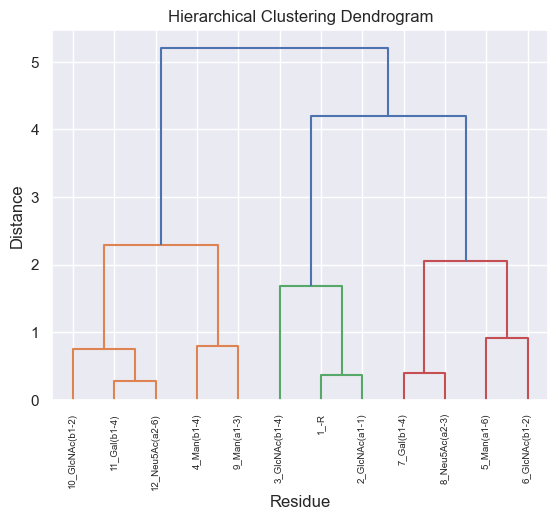

In [116]:
# clustering of correlated residues
show_correlation_dendrogram(mx, font_size = 7)

icoord[[5.0, 5.0, 15.0, 15.0], [25.0, 25.0, 35.0, 35.0], [10.0, 10.0, 30.0, 30.0]]
dcoord[[0.0, 0.6031742614648258, 0.6031742614648258, 0.0], [0.0, 0.6303683911333765, 0.6303683911333765, 0.0], [0.6031742614648258, 4.291109910562439, 4.291109910562439, 0.6303683911333765]]
ivl['1_-R', '2_GlcNAc(a1-1)', '3_Gal(b1-3)', '4_Neu5Gc(a2-3)']
leaves[0, 1, 2, 3]
color_list['C1', 'C2', 'C0']
leaves_color_list['C1', 'C1', 'C2', 'C2']


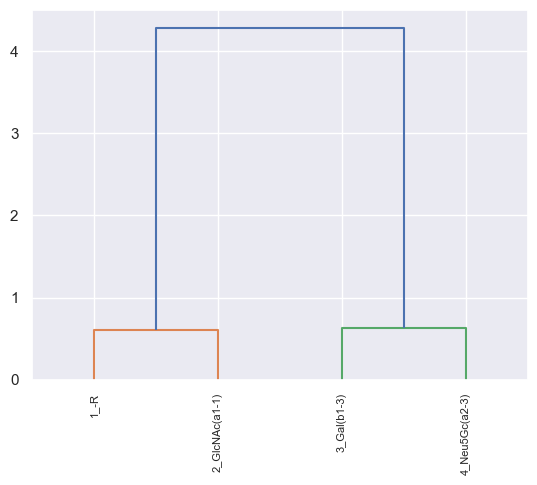

In [194]:
def show_correlation_dendrogram(corr_df, font_size = 1):
    ### Create a hierarchical clustering dendrogram from a correlation matrix as dataframe (corr_df)
    
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    dendrogram = hierarchy.dendrogram(hierarchy.linkage(corr_df.values, method='ward'),
                                    labels=corr_df.columns,
                                    leaf_rotation=90,
                                    leaf_font_size=8,ax=ax
                                    )
    for d in dendrogram :
        print(d + str(dendrogram[d]))
    #ax.tick_params(axis='x', which='major', labelsize=font_size)
    #plt.title('Hierarchical Clustering Dendrogram')
    #plt.xlabel('Residue')
    #plt.ylabel('Distance')
    #plt.show()

show_correlation_dendrogram(mx)

# Step 9 - Contact frequency table and heatmap

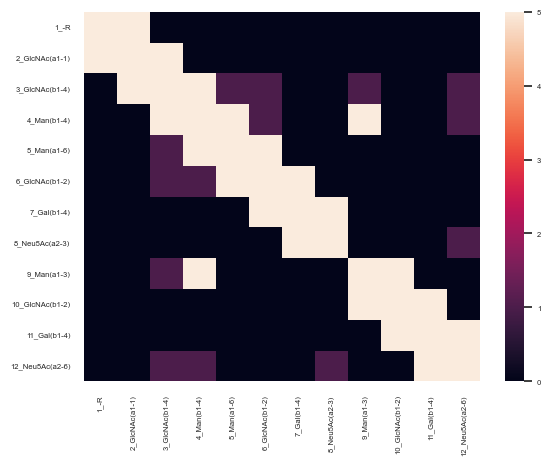

In [117]:
# Given a specific threshold, count the frequency of contact (= two residues being closer than threshold) across multiple dataframes
isft = inter_structure_frequency_table(dfs, threshold = 3)
monosaccharide_contact_map(isft)

# Step 10 - Monosaccharide preferences

6.344499999999999


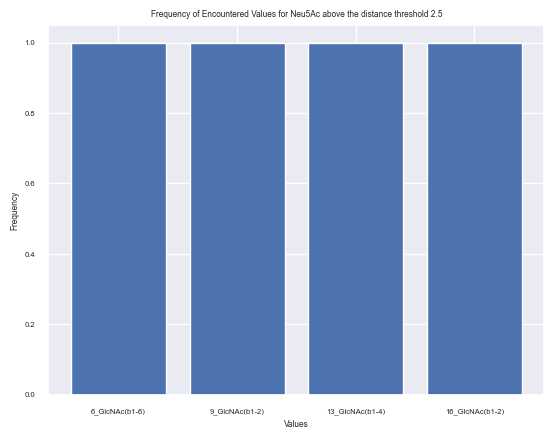

In [75]:
show_monosaccharide_preference_structure(dist_table,'Neu5Ac',2.5,mode='default')

6.344499999999999


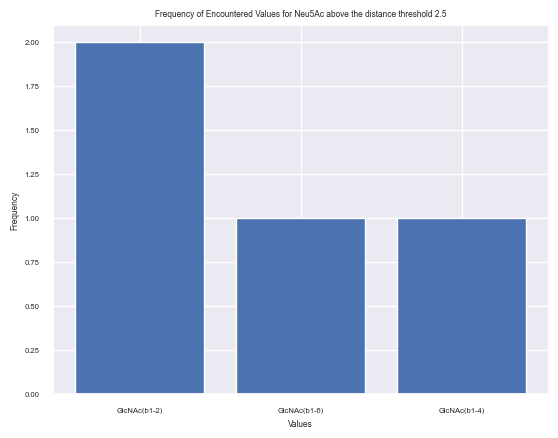

In [76]:
show_monosaccharide_preference_structure(dist_table,'Neu5Ac',2.5,mode='monolink')

6.344499999999999


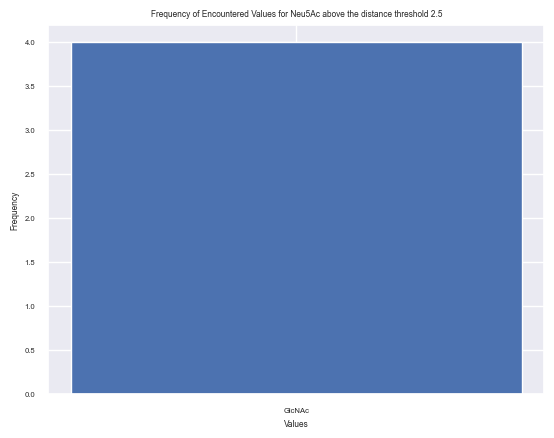

In [77]:
show_monosaccharide_preference_structure(dist_table,'Neu5Ac',2.5,mode='monosaccharide')

Neu5Ac(a2-3)Gal(b1-4)GlcNAc(b1-2)[Neu5Ac(a2-3)Gal(b1-4)GlcNAc(b1-4)]Man(a1-3)[Neu5Ac(a2-3)Gal(b1-4)GlcNAc(b1-2)[Neu5Ac(a2-3)Gal(b1-4)GlcNAc(b1-6)]Man(a1-6)]Man(b1-4)GlcNAc(b1-4)GlcNAc/Neu5Ac(a2-3)Gal(b1-4)GlcNAc(b1-2)[Neu5Ac(a2-3)Gal(b1-4)GlcNAc(b1-4)]Man(a1-3)[Neu5Ac(a2-3)Gal(b1-4)GlcNAc(b1-2)[Neu5Ac(a2-3)Gal(b1-4)GlcNAc(b1-6)]Man(a1-6)]Man(b1-4)GlcNAc(b1-4)GlcNAc_beta_0.pdb
threshold:2.2
glycowork and glycontact do not agree on the list of covalent linkages in this glycan. It is probable that glycontact encountered a problem with PDB monosaccharide conversion, or detecting linkages
threshold:2.4
glycowork and glycontact do not agree on the list of covalent linkages in this glycan. It is probable that glycontact encountered a problem with PDB monosaccharide conversion, or detecting linkages
threshold:2.5
glycowork and glycontact do not agree on the list of covalent linkages in this glycan. It is probable that glycontact encountered a problem with PDB monosaccharide conversion, or dete

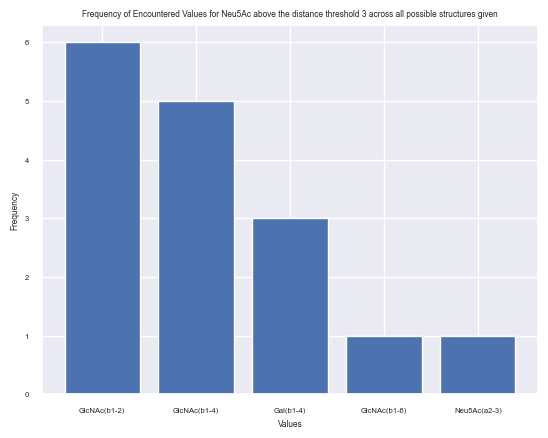

In [83]:
multi_glycan_monosaccharide_preference_structure(prefix = iupac_list[0],suffix= "beta",glycan_sequence=iupac_list[0],monosaccharide="Neu5Ac",threshold=3, mode= "monolink")